In [1]:
# Cell 1: imports & small helpers
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import country_converter as coco

sns.set(style="whitegrid")
os.makedirs("data/processed", exist_ok=True)
os.makedirs("outputs/tables", exist_ok=True)
os.makedirs("outputs/figures", exist_ok=True)

In [4]:
# Cell 2: load dataset
path=r"\Users\cgspl\Downloads\ClimateScope_project-main (5)\ClimateScope_project-main\data\raw\GlobalWeatherRepository.csv"
print("Trying to load:", path)
df = pd.read_csv(path)
print("Loaded shape:", df.shape)
df.head()

Trying to load: \Users\cgspl\Downloads\ClimateScope_project-main (5)\ClimateScope_project-main\data\raw\GlobalWeatherRepository.csv
Loaded shape: (94901, 41)


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [5]:
# Cell 3: find candidate date columns and parse one
candidates = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower() or 'last' in c.lower()]
print("Date candidates:", candidates)

# common default column names; change if your filename uses something else
if 'last_updated' in df.columns:
    df['last_updated'] = pd.to_datetime(df['last_updated'], errors='coerce')
elif candidates:
    df[candidates[0]] = pd.to_datetime(df[candidates[0]], errors='coerce')
    df.rename(columns={candidates[0]:'last_updated'}, inplace=True)
else:
    print("No date column auto-detected — you will need to create one or check column names:", df.columns)

# create year/month/day for aggregation
df['year'] = df['last_updated'].dt.year
df['month'] = df['last_updated'].dt.month
df['day'] = df['last_updated'].dt.day
df[['last_updated','year','month']].head()


Date candidates: ['timezone', 'last_updated_epoch', 'last_updated']


,last_updated,year,month
0,2024-05-16 13:15:00,2024,5
1,2024-05-16 10:45:00,2024,5
2,2024-05-16 09:45:00,2024,5
3,2024-05-16 10:45:00,2024,5
4,2024-05-16 09:45:00,2024,5


In [6]:
# Cell 4: coerce numeric columns & report missingness
# heuristics: numeric-like column names
num_guess = [c for c in df.columns if any(k in c.lower() for k in ['temp','precip','humid','wind','speed','pressure'])]
# also include actual numeric dtypes
num_cols = list(df.select_dtypes(include=[np.number]).columns.union(num_guess))
# coerce guessed numeric columns
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
print("Top missing columns (percent):\n", missing_pct.head(20))
print("\nNumeric columns used for analysis:", num_cols)


Top missing columns (percent):
 wind_direction            100.0
country                     0.0
latitude                    0.0
location_name               0.0
timezone                    0.0
last_updated_epoch          0.0
last_updated                0.0
temperature_celsius         0.0
temperature_fahrenheit      0.0
condition_text              0.0
wind_mph                    0.0
longitude                   0.0
wind_kph                    0.0
wind_degree                 0.0
pressure_mb                 0.0
pressure_in                 0.0
precip_mm                   0.0
precip_in                   0.0
humidity                    0.0
cloud                       0.0
dtype: float64

Numeric columns used for analysis: ['air_quality_Carbon_Monoxide', 'air_quality_Nitrogen_dioxide', 'air_quality_Ozone', 'air_quality_PM10', 'air_quality_PM2.5', 'air_quality_Sulphur_dioxide', 'air_quality_gb-defra-index', 'air_quality_us-epa-index', 'cloud', 'day', 'feels_like_celsius', 'feels_like_fahrenheit',

In [7]:
# Cell 5: save cleaned snapshot for Milestone 2
clean_path = "data/processed/cleaned_dataset_for_milestone2.csv"
df.to_csv(clean_path, index=False)
print("Saved cleaned snapshot to:", clean_path)


Saved cleaned snapshot to: data/processed/cleaned_dataset_for_milestone2.csv


In [8]:
# Cell 6: summary stats for numeric columns
summary = df[num_cols].describe().T
summary['missing_pct'] = (df[num_cols].isna().sum()/len(df)*100).values
display(summary.round(3))
summary.to_csv("outputs/tables/global_numeric_summary.csv")
print("Saved outputs/tables/global_numeric_summary.csv")


,count,mean,std,min,25%,50%,75%,max,missing_pct
air_quality_Carbon_Monoxide,94901.0,5.170040e+02,8.468620e+02,-9.999000e+03,2.370000e+02,3.274500e+02,5.069000e+02,3.887940e+04,0.0
air_quality_Nitrogen_dioxide,94901.0,1.570700e+01,2.601800e+01,0.000000e+00,1.295000e+00,4.810000e+00,1.776000e+01,4.277000e+02,0.0
air_quality_Ozone,94901.0,6.309500e+01,3.243800e+01,0.000000e+00,4.200000e+01,6.000000e+01,8.000000e+01,4.807000e+02,0.0
air_quality_PM10,94901.0,5.396700e+01,1.647820e+02,-1.848150e+03,1.073000e+01,2.220000e+01,4.630000e+01,6.037290e+03,0.0
air_quality_PM2.5,94901.0,2.618900e+01,4.101300e+01,1.680000e-01,7.400000e+00,1.517000e+01,2.997000e+01,1.614100e+03,0.0
air_quality_Sulphur_dioxide,94901.0,1.128800e+01,4.120300e+01,-9.999000e+03,8.000000e-01,2.405000e+00,9.065000e+00,5.213300e+02,0.0
air_quality_gb-defra-index,94901.0,2.765000e+00,2.574000e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,1.000000e+01,0.0
air_quality_us-epa-index,94901.0,1.761000e+00,9.830000e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,6.000000e+00,0.0
cloud,94901.0,3.934800e+01,3.375100e+01,0.000000e+00,0.000000e+00,2.600000e+01,7.500000e+01,1.000000e+02,0.0
day,94901.0,1.574000e+01,8.811000e+00,1.000000e+00,8.000000e+00,1.600000e+01,2.300000e+01,3.100000e+01,0.0


Saved outputs/tables/global_numeric_summary.csv


In [9]:
# Cell 7: per-country stats (mean/median/std/count)
if 'country' not in df.columns:
    print("No 'country' column found. Check df.columns:", df.columns)
else:
    country_stats = df.groupby('country')[num_cols].agg(['mean','median','std','count'])
    country_stats.columns = ['_'.join(col).strip() for col in country_stats.columns.values]
    country_stats = country_stats.reset_index()
    country_stats.to_csv("outputs/tables/country_stats.csv", index=False)
    display(country_stats.head())
    print("Saved outputs/tables/country_stats.csv")


,country,air_quality_Carbon_Monoxide_mean,air_quality_Carbon_Monoxide_median,air_quality_Carbon_Monoxide_std,air_quality_Carbon_Monoxide_count,air_quality_Nitrogen_dioxide_mean,air_quality_Nitrogen_dioxide_median,air_quality_Nitrogen_dioxide_std,air_quality_Nitrogen_dioxide_count,air_quality_Ozone_mean,...,wind_kph_std,wind_kph_count,wind_mph_mean,wind_mph_median,wind_mph_std,wind_mph_count,year_mean,year_median,year_std,year_count
0,Afghanistan,745.086066,640.10,412.784784,488,7.429969,5.475,5.802339,488,118.551434,...,7.464116,488,6.233197,4.50,4.643041,488,2024.530738,2025.0,0.499566,488
1,Albania,283.965471,288.60,60.435466,488,13.813238,12.395,11.016009,488,79.232172,...,5.531055,488,5.975000,4.90,3.440582,488,2024.530738,2025.0,0.499566,488
2,Algeria,332.758008,318.20,94.145335,487,35.864538,31.265,25.565882,487,72.146612,...,7.907728,487,8.240452,7.20,4.913204,487,2024.531828,2025.0,0.499499,487
3,Andorra,189.514453,186.85,30.368607,488,1.215111,0.740,1.469346,488,69.040574,...,4.018480,488,5.344877,4.90,2.502856,488,2024.530738,2025.0,0.499566,488
4,Angola,614.365984,532.80,321.761032,488,10.037818,8.510,6.485723,488,94.631352,...,5.438993,488,6.145492,5.25,3.381934,488,2024.530738,2025.0,0.499566,488


Saved outputs/tables/country_stats.csv


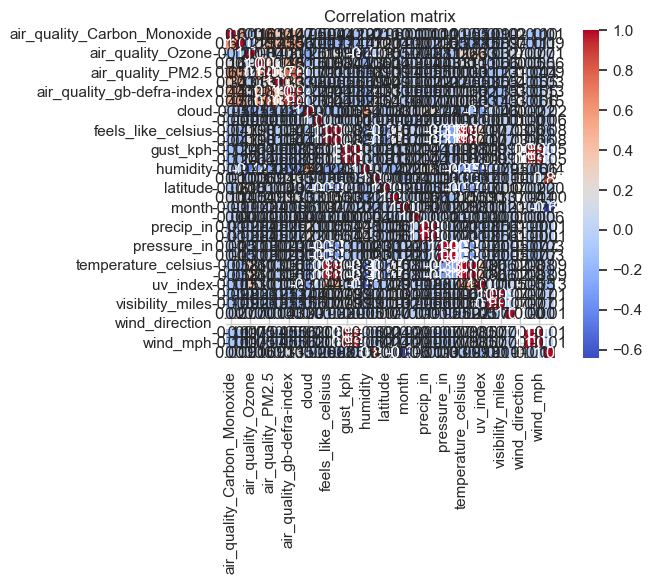

Saved outputs/figures/correlation_matrix.png


In [10]:
# Cell 8: correlation heatmap (matplotlib/seaborn)
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation matrix")
plt.tight_layout()
plt.savefig("outputs/figures/correlation_matrix.png", dpi=150)
plt.show()
print("Saved outputs/figures/correlation_matrix.png")


In [11]:
# Cell 9: monthly aggregation and global time series for a main variable
main_var = 'temperature' if 'temperature' in df.columns else num_cols[0]
monthly = df.groupby(['year','month'])[main_var].mean().reset_index().dropna()
monthly['date'] = pd.to_datetime(monthly['year'].astype(int).astype(str) + '-' + monthly['month'].astype(int).astype(str) + '-15')

fig = px.line(monthly, x='date', y=main_var, title=f'Global monthly mean - {main_var}')
fig.show()
fig.write_html("outputs/figures/global_monthly_time_series.html")
print("Saved outputs/figures/global_monthly_time_series.html")


Saved outputs/figures/global_monthly_time_series.html


In [12]:
# Cell 10: per-country example
sample_country = 'India'  # change to any country present in your df
if 'country' in df.columns and sample_country in df['country'].unique():
    c_monthly = df[df['country']==sample_country].groupby(['year','month'])[main_var].mean().reset_index().dropna()
    c_monthly['date'] = pd.to_datetime(c_monthly['year'].astype(int).astype(str) + '-' + c_monthly['month'].astype(int).astype(str) + '-15')
    fig2 = px.line(c_monthly, x='date', y=main_var, title=f'{sample_country} monthly mean - {main_var}')
    fig2.show()
    fig2.write_html(f"outputs/figures/{sample_country}_monthly_{main_var}.html")
    print("Saved outputs/figures/{sample_country}_monthly_{main_var}.html")
else:
    print("Sample country not found. Available (first 20):", df['country'].dropna().unique()[:20])


Saved outputs/figures/{sample_country}_monthly_{main_var}.html


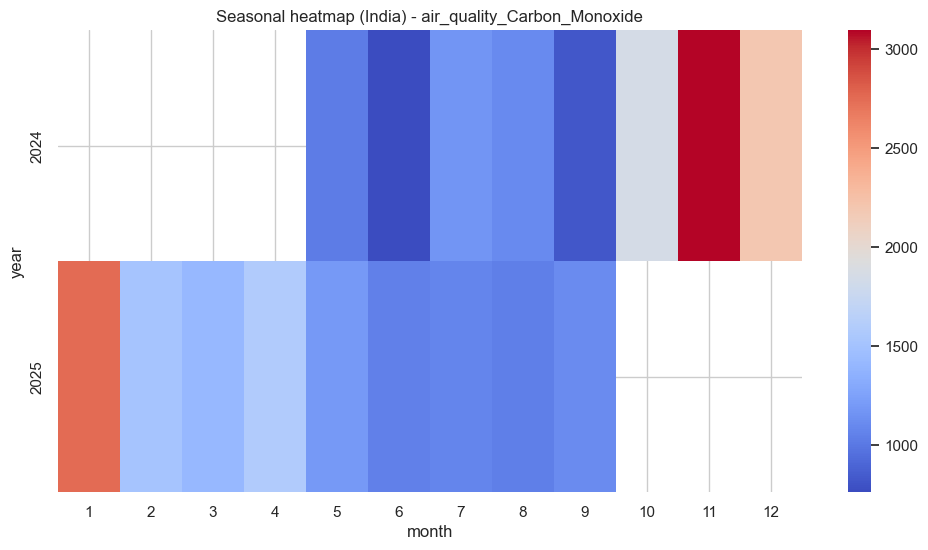

Saved outputs/figures/{country_for_heat}_seasonal_heatmap.png


In [13]:
# Cell 11: seasonal heatmap
country_for_heat = sample_country
if 'country' in df.columns and country_for_heat in df['country'].unique():
    pivot = (df[df['country']==country_for_heat]
             .groupby(['year','month'])[main_var]
             .mean()
             .reset_index()
             .pivot(index='year', columns='month', values=main_var))
    plt.figure(figsize=(12,6))
    sns.heatmap(pivot, cmap='coolwarm')
    plt.title(f'Seasonal heatmap ({country_for_heat}) - {main_var}')
    plt.savefig(f"outputs/figures/{country_for_heat}_seasonal_heatmap.png", dpi=150)
    plt.show()
    print("Saved outputs/figures/{country_for_heat}_seasonal_heatmap.png")
else:
    print("Country missing for heatmap.")


In [14]:
# Cell 12: detect extremes
# precipitation extremes (top 1% by value)
if 'precipitation' in df.columns:
    p99 = df['precipitation'].quantile(0.99)
    extreme_precip = df[df['precipitation'] > p99].sort_values('precipitation', ascending=False)
    extreme_precip.to_csv("outputs/tables/extreme_precip_top1pct.csv", index=False)
    print("Saved outputs/tables/extreme_precip_top1pct.csv (threshold: {:.2f})".format(p99))

# temperature extremes by z-score (> 3 sigma)
if 'temperature' in df.columns:
    df['temp_z'] = (df['temperature'] - df['temperature'].mean())/df['temperature'].std()
    extreme_temp = df[df['temp_z'].abs() > 3].sort_values('temp_z', key=lambda s: s.abs(), ascending=False)
    extreme_temp.to_csv("outputs/tables/extreme_temp_3sigma.csv", index=False)
    print("Saved outputs/tables/extreme_temp_3sigma.csv (3-sigma rule)")
